In [1]:
# Dice Loss和跳跃连接

In [2]:
import os
import torch
import torch.nn as nn
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

def dice_loss(pred, target, smooth=1.):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (
        pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) + smooth)
    return 1 - dice.mean()


In [3]:
class HairMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_img=None, transform_mask=None):
        self.image_list = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img = Image.open(os.path.join(self.image_dir, img_name)).convert('RGB')
        mask = Image.open(os.path.join(self.mask_dir, img_name)).convert('L')
        if self.transform_img:
            img = self.transform_img(img)
        if self.transform_mask:
            mask = self.transform_mask(mask)
        return img, mask


In [4]:
class REBNCONV(nn.Module):
    def __init__(self, in_ch, out_ch, dirate=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1 * dirate, dilation=1 * dirate),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class RSU7(nn.Module):
    def __init__(self, in_ch, mid_ch, out_ch):
        super().__init__()
        self.rebnconvin = REBNCONV(in_ch, out_ch)
        self.stage1 = REBNCONV(out_ch, mid_ch)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage2 = REBNCONV(mid_ch, mid_ch)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage3 = REBNCONV(mid_ch, mid_ch)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage4 = REBNCONV(mid_ch, mid_ch)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage5 = REBNCONV(mid_ch, mid_ch)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage6 = REBNCONV(mid_ch, mid_ch)
        self.pool6 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        self.stage7 = REBNCONV(mid_ch, mid_ch)

        self.stage6d = REBNCONV(mid_ch * 2, mid_ch)
        self.stage5d = REBNCONV(mid_ch * 2, mid_ch)
        self.stage4d = REBNCONV(mid_ch * 2, mid_ch)
        self.stage3d = REBNCONV(mid_ch * 2, mid_ch)
        self.stage2d = REBNCONV(mid_ch * 2, mid_ch)
        self.stage1d = REBNCONV(mid_ch * 2, out_ch)

    def forward(self, x):
        hxin = self.rebnconvin(x)
        hx1 = self.stage1(hxin)
        hx2 = self.stage2(self.pool1(hx1))
        hx3 = self.stage3(self.pool2(hx2))
        hx4 = self.stage4(self.pool3(hx3))
        hx5 = self.stage5(self.pool4(hx4))
        hx6 = self.stage6(self.pool5(hx5))
        hx7 = self.stage7(self.pool6(hx6))

        hx6d = self.stage6d(torch.cat((nn.functional.interpolate(hx7, size=hx6.shape[2:], mode='bilinear', align_corners=False), hx6), dim=1))
        hx5d = self.stage5d(torch.cat((nn.functional.interpolate(hx6d, size=hx5.shape[2:], mode='bilinear', align_corners=False), hx5), dim=1))
        hx4d = self.stage4d(torch.cat((nn.functional.interpolate(hx5d, size=hx4.shape[2:], mode='bilinear', align_corners=False), hx4), dim=1))
        hx3d = self.stage3d(torch.cat((nn.functional.interpolate(hx4d, size=hx3.shape[2:], mode='bilinear', align_corners=False), hx3), dim=1))
        hx2d = self.stage2d(torch.cat((nn.functional.interpolate(hx3d, size=hx2.shape[2:], mode='bilinear', align_corners=False), hx2), dim=1))
        hx1d = self.stage1d(torch.cat((nn.functional.interpolate(hx2d, size=hx1.shape[2:], mode='bilinear', align_corners=False), hx1), dim=1))
        return hx1d + hxin

class U2NET(nn.Module):
    def __init__(self, in_ch=3, out_ch=1):
        super().__init__()
        self.stage1 = RSU7(in_ch, 32, 64)
        self.outconv = nn.Conv2d(64, out_ch, 1)

    def forward(self, x):
        x = self.stage1(x)
        x = self.outconv(x)
        return torch.sigmoid(x)


In [5]:
transform_img = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])
transform_mask = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = HairMaskDataset(
    image_dir="/root/autodl-fs/skin_hair_dataset/alignment/photo with hair",
    mask_dir="/root/autodl-fs/skin_hair_dataset/alignment/mask",
    transform_img=transform_img,
    transform_mask=transform_mask
)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = U2NET().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(40):
    model.train()
    total_loss = 0
    for imgs, masks in dataloader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = dice_loss(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss / len(dataloader):.4f}")

torch.save(model.state_dict(), "hair_seg_u2net_dice.pth")
print("✅ 模型已保存：hair_seg_u2net_dice.pth")


Epoch 1: Loss = 0.8708
Epoch 2: Loss = 0.8181
Epoch 3: Loss = 0.7954
Epoch 4: Loss = 0.7701
Epoch 5: Loss = 0.7481
Epoch 6: Loss = 0.7212
Epoch 7: Loss = 0.7073
Epoch 8: Loss = 0.6818
Epoch 9: Loss = 0.6629
Epoch 10: Loss = 0.6451
Epoch 11: Loss = 0.6324
Epoch 12: Loss = 0.6223
Epoch 13: Loss = 0.6029
Epoch 14: Loss = 0.5999
Epoch 15: Loss = 0.5860
Epoch 16: Loss = 0.5706
Epoch 17: Loss = 0.5656
Epoch 18: Loss = 0.5539
Epoch 19: Loss = 0.5367
Epoch 20: Loss = 0.5170
Epoch 21: Loss = 0.5059
Epoch 22: Loss = 0.5006
Epoch 23: Loss = 0.4879
Epoch 24: Loss = 0.4677
Epoch 25: Loss = 0.4592
Epoch 26: Loss = 0.4446
Epoch 27: Loss = 0.4318
Epoch 28: Loss = 0.4205
Epoch 29: Loss = 0.4131
Epoch 30: Loss = 0.4042
Epoch 31: Loss = 0.3832
Epoch 32: Loss = 0.3716
Epoch 33: Loss = 0.3656
Epoch 34: Loss = 0.3575
Epoch 35: Loss = 0.3445
Epoch 36: Loss = 0.3463
Epoch 37: Loss = 0.3340
Epoch 38: Loss = 0.3251
Epoch 39: Loss = 0.3202
Epoch 40: Loss = 0.3209
✅ 模型已保存：hair_seg_u2net_dice.pth


✅ 已保存：./inpainted_results/inpainted_ISIC2019_0000461.jpg


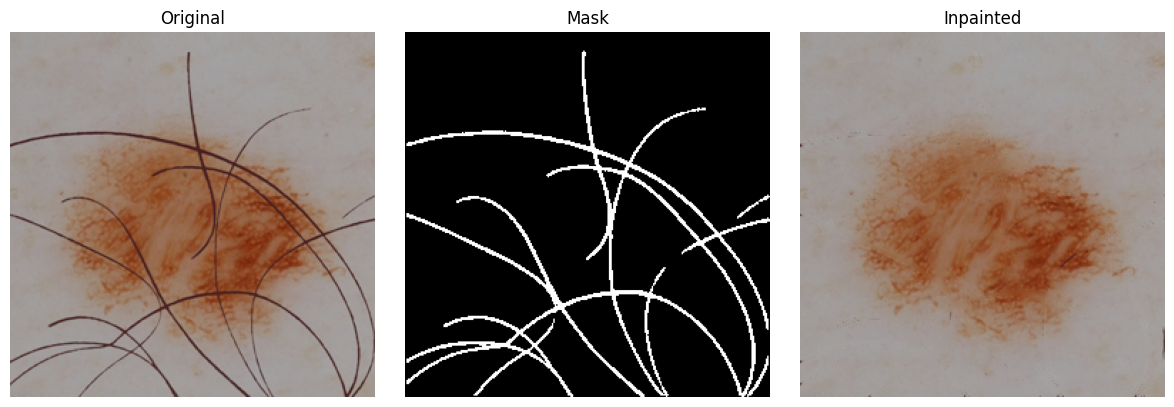

✅ 已保存：./inpainted_results/inpainted_ISIC2019_0031696.jpg


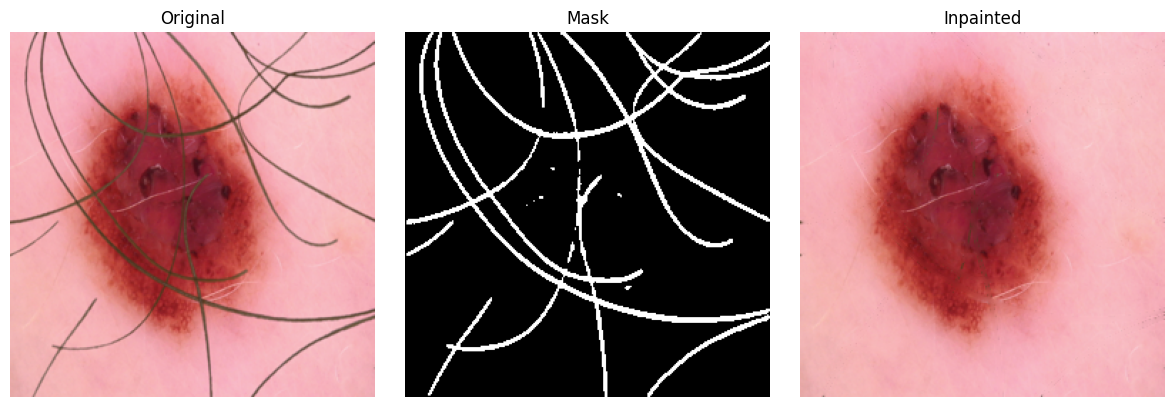

✅ 已保存：./inpainted_results/inpainted_ISIC2019_0028326.jpg


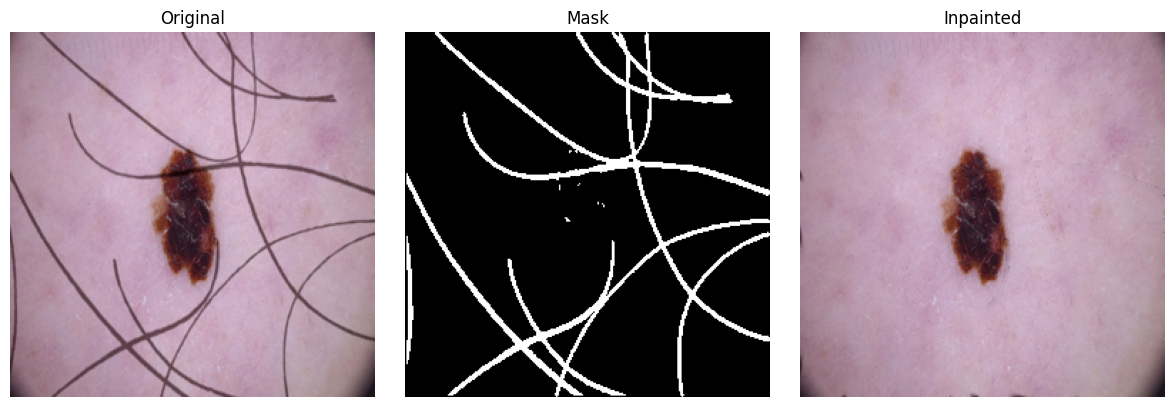

In [6]:
# ---------- 5. 毛发去除函数 ----------
def inpaint_image(image_path, save_path=None):
    model.eval()
    image = Image.open(image_path).convert("RGB").resize((256, 256))
    input_tensor = transform_img(image).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_mask = model(input_tensor).squeeze().cpu().numpy()
    binary_mask = (pred_mask > 0.5).astype(np.uint8) * 255
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    inpainted = cv2.inpaint(image_cv, binary_mask, 3, cv2.INPAINT_TELEA)
    if save_path:
        cv2.imwrite(save_path, inpainted)
    return image_cv, binary_mask, inpainted

# ---------- 6. 测试、可视化与保存 Inpainted 图像 ----------
test_images = ['ISIC2019_0000461.jpg', 'ISIC2019_0031696.jpg', 'ISIC2019_0028326.jpg']
test_dir = "/root/autodl-fs/skin_hair_dataset/alignment/photo with hair"
save_dir = "./inpainted_results"  # 保存目录

# 创建保存目录
os.makedirs(save_dir, exist_ok=True)

for img_name in test_images:
    img_path = os.path.join(test_dir, img_name)
    
    # 获取原图、掩码、修复图像
    original, mask, inpainted = inpaint_image(img_path)
    
    # 保存 inpainted 图像
    save_path = os.path.join(save_dir, f"inpainted_{img_name}")
    cv2.imwrite(save_path, inpainted)
    print(f"✅ 已保存：{save_path}")
    
    # 可视化显示
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB)); plt.title("Original"); plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap="gray"); plt.title("Mask"); plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB)); plt.title("Inpainted"); plt.axis("off")
    plt.tight_layout(); plt.show()


In [7]:
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from sewar.full_ref import uqi

# ---------- 7. 图像质量指标计算函数 ----------
def calculate_metrics(pred_img, gt_img):
    pred_img = pred_img.astype(np.float32) / 255.0
    gt_img = gt_img.astype(np.float32) / 255.0

    h, w = pred_img.shape[:2]
    win_size = min(7, h, w)
    if win_size % 2 == 0:
        win_size -= 1

    mse = mean_squared_error(gt_img, pred_img)
    psnr = peak_signal_noise_ratio(gt_img, pred_img, data_range=1.0)
    ssim = structural_similarity(gt_img, pred_img, data_range=1.0, channel_axis=2, win_size=win_size)
    uqi_val = uqi(gt_img, pred_img)

    return mse, psnr, ssim, uqi_val

image_dir = "/root/autodl-fs/skin_hair_dataset/alignment/photo with hair"
original_dir = "/root/autodl-fs/skin_hair_dataset/alignment/oryginal"  # 没有毛发的 ground-truth 原图
image_list = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

# 累加指标
total_mse, total_psnr, total_ssim, total_uqi = 0, 0, 0, 0
valid_count = 0

for img_name in image_list:
    try:
        # 推理修复图像
        img_path = os.path.join(image_dir, img_name)
        original, _, inpainted = inpaint_image(img_path)

        # 加载 ground-truth（无毛发）图像
        gt_path = os.path.join(original_dir, img_name)
        if not os.path.exists(gt_path):
            print(f"❌ ground-truth 缺失: {img_name}")
            continue
        gt_img = cv2.imread(gt_path)
        gt_img = cv2.resize(gt_img, (256, 256))

        # 计算指标
        mse, psnr, ssim, uqi_val = calculate_metrics(inpainted, gt_img)
        total_mse += mse
        total_psnr += psnr
        total_ssim += ssim
        total_uqi += uqi_val
        valid_count += 1
        print(f"✅ {img_name}  |  MSE: {mse:.4f}  PSNR: {psnr:.2f}  SSIM: {ssim:.4f}  UQI: {uqi_val:.4f}")
    except Exception as e:
        print(f"⚠️ 处理失败 {img_name}：{str(e)}")

# 平均指标打印
if valid_count > 0:
    print("\n📊 平均指标：")
    print(f"  MSE  : {total_mse / valid_count:.6f}")
    print(f"  PSNR : {total_psnr / valid_count:.2f} dB")
    print(f"  SSIM : {total_ssim / valid_count:.4f}")
    print(f"  UQI  : {total_uqi / valid_count:.4f}")
else:
    print("❌ 没有成功评估任何图像")


✅ ISIC2017_0000026.jpg  |  MSE: 0.0015  PSNR: 28.30  SSIM: 0.9802  UQI: 0.9998
✅ ISIC2017_0000081.jpg  |  MSE: 0.0002  PSNR: 37.43  SSIM: 0.9264  UQI: 0.9997
✅ ISIC2017_0000082.jpg  |  MSE: 0.0001  PSNR: 40.13  SSIM: 0.9463  UQI: 0.9988
✅ ISIC2017_0000147.jpg  |  MSE: 0.0004  PSNR: 33.91  SSIM: 0.9323  UQI: 0.9983
✅ ISIC2017_0000150.jpg  |  MSE: 0.0002  PSNR: 37.56  SSIM: 0.9237  UQI: 0.9989
✅ ISIC2017_0000151.jpg  |  MSE: 0.0001  PSNR: 40.78  SSIM: 0.9548  UQI: 0.9992
✅ ISIC2017_0000152.jpg  |  MSE: 0.0003  PSNR: 35.65  SSIM: 0.9240  UQI: 0.9971
✅ ISIC2017_0000153.jpg  |  MSE: 0.0002  PSNR: 37.90  SSIM: 0.9256  UQI: 0.9997
✅ ISIC2017_0000154.jpg  |  MSE: 0.0002  PSNR: 38.08  SSIM: 0.9371  UQI: 0.9995
✅ ISIC2017_0001148.jpg  |  MSE: 0.0001  PSNR: 40.64  SSIM: 0.9567  UQI: 0.9998
✅ ISIC2017_0012137.jpg  |  MSE: 0.0003  PSNR: 35.64  SSIM: 0.9163  UQI: 0.9995
✅ ISIC2017_0015079.jpg  |  MSE: 0.0004  PSNR: 33.90  SSIM: 0.8732  UQI: 0.9963
✅ ISIC2019_0000171.jpg  |  MSE: 0.0016  PSNR: 27.88 